In [78]:
import pickle

images = []
lesions = []
from skimage.io import imread
import os
from pathlib import Path
root = '../input/segment/PH2Dataset/'

for d in Path(root+'PH2 Dataset images').iterdir():
    for imd in Path(d).iterdir():
        if str(imd).endswith('_Dermoscopic_Image'):
            images.append(imread(next(imd.iterdir())))
        if str(imd).endswith('_lesion'):
            lesions.append(imread(next(imd.iterdir())))

In [79]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [80]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
print(len(lesions))

Loaded 200 images
200


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

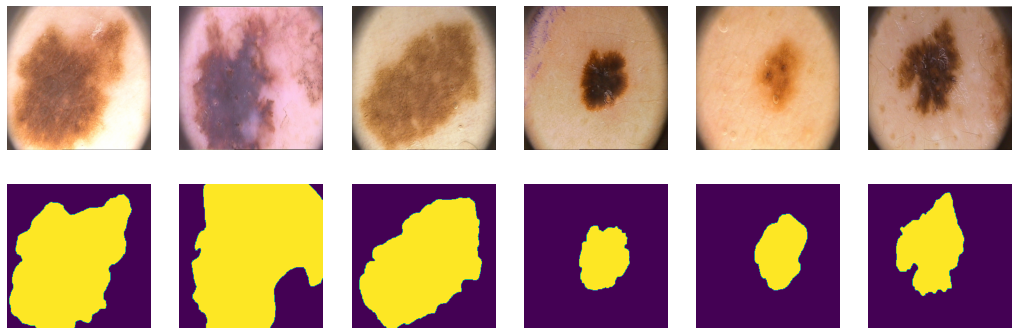

In [81]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [82]:
import torch
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [83]:
print(len(tr), len(val), len(ts))

100 50 50


In [84]:
from torch.utils.data import DataLoader
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [87]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(2, 2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(2, 2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=1,
                      padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.Conv2d(in_channels=1024,
                      out_channels=512,
                      kernel_size=1,
                      padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(in_channels=1,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [88]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [89]:
def bce_loss(y_real, y_pred):
    loss = y_pred - y_real * y_pred + (1 + torch.exp(-y_pred)).log()
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [90]:
from tqdm import tqdm

In [91]:
def train(model, opt, scheduler, loss_fn, score_fn, epochs, data_tr, data_val):
    torch.cuda.empty_cache()
    tr_loss = []
    val_loss = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        tr_avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            tr_avg_loss += loss.cpu().item() / len(data_tr)
        tr_loss.append(tr_avg_loss)
        toc = time()
        print('train loss: %f' % tr_avg_loss)

        avg_loss_val = 0
        model.eval()
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(device)).detach().cpu()
                loss = loss_fn(Y_val, Y_hat)
                avg_loss_val += loss.item() / len(data_val)
        val_loss.append(avg_loss_val)
        toc = time()
        print('val loss: %f' % avg_loss_val)
        avg_score_val = score_fn(model, iou_pytorch, data_val)
        val_score.append(avg_score_val)
        print('val score: %f' % avg_score_val)

        if scheduler:
            scheduler.step(avg_score_val)

      
    return tr_loss, val_loss, val_score

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [92]:
def predict(model, data):
    model.eval()  # testing mode
    X_batch = [ X_batch for X_batch, _ in data]
    with torch.no_grad():
        Y_pred = model(X_batch.to(device)).sigmoid()
        Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.5)
    return np.array(Y_pred)

In [93]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        with torch.no_grad():
            Y_pred = model(X_batch.to(device)).sigmoid()
            Y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.5)
            scores += metric(Y_pred.cpu(), Y_label).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [107]:
model = SegNet().to(device)

In [ ]:
max_epochs = 120
optim = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_loss_bce, val_loss_bce, val_score_bce = train(model, optim, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val)

In [109]:
torch.save(model.state_dict(), 'segnet_bce.pt')

In [110]:
with open('tr_loss_bce.pickle', 'wb') as f:
    pickle.dump(tr_loss_bce, f)

In [111]:
with open('val_loss_bce.pickle', 'wb') as f:
    pickle.dump(val_loss_bce, f)
with open('val_score_bce.pickle', 'wb') as f:
    pickle.dump(val_score_bce, f)

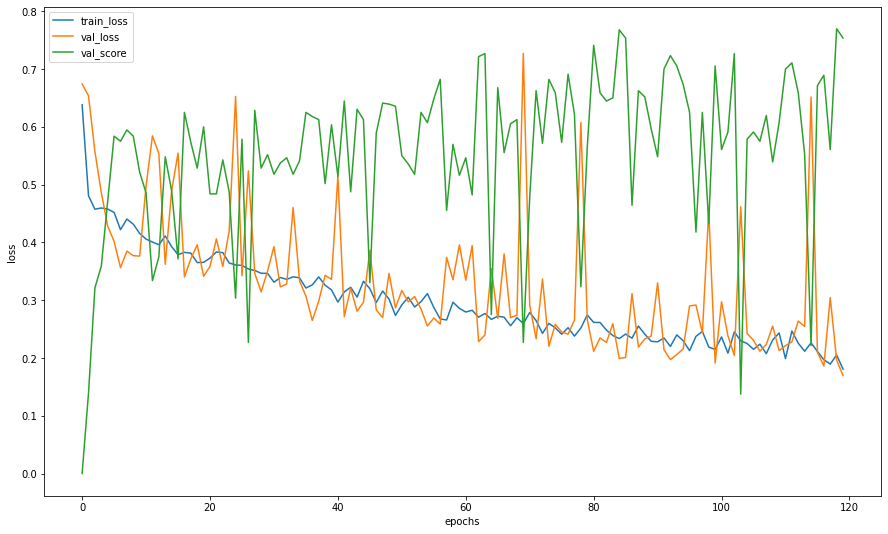

In [112]:
plt.figure(figsize=(15, 9))
plt.plot(tr_loss_bce, label="train_loss")
plt.plot(val_loss_bce, label="val_loss")
plt.plot(val_score_bce, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [113]:
model_bce = SegNet().to(device)

In [114]:
model_bce.load_state_dict(torch.load('segnet_bce.pt'))

<All keys matched successfully>

In [115]:
print(score_model(model_bce, iou_pytorch, data_val), score_model(model_bce, iou_pytorch, data_ts))

0.7321428656578064 0.7107142976352147


In [116]:
def plot_items(model, loader, cnt):

    model.eval()
    X, Y = next(iter(loader))
    X = X.to(device)
    Y_pred = model(X)

    p = Y_pred.detach().cpu()
    p_post = torch.ones_like(p) * (p > 0.1)
    y = Y
    
    plt.figure(figsize=(15, 10))
    for i in range(cnt):
        plt.subplot(3, cnt, i+1+cnt*0)
        plt.imshow(np.rollaxis(p[i,0].numpy(), 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        
        plt.subplot(3, cnt, i+1+cnt*1)
        plt.imshow(np.rollaxis(p_post[i,0].numpy(), 0), cmap='gray')
        plt.title('Post-processing')
        plt.axis('off')

        plt.subplot(3, cnt, i+1+cnt*2)
        plt.imshow(np.rollaxis(y[i,0].numpy(), 0), cmap='gray')
        plt.title('Real')
        plt.axis('off')

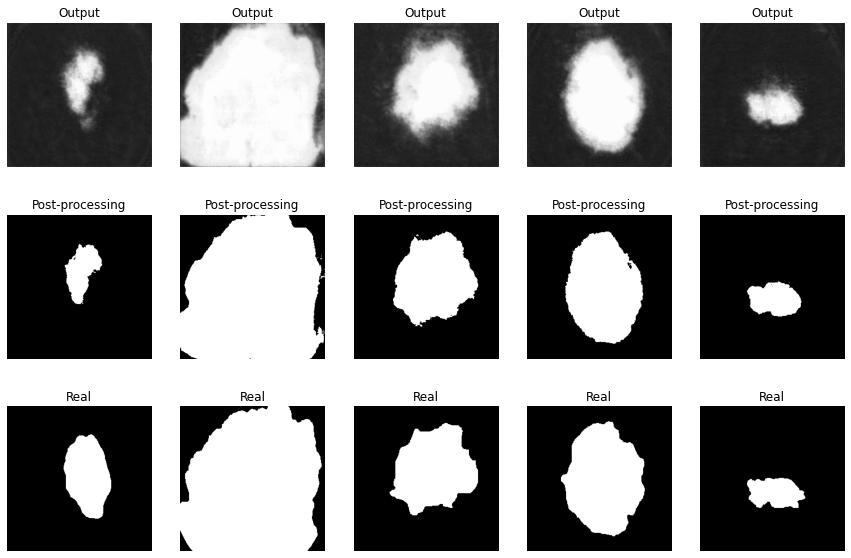

In [117]:
plot_items(model_bce, data_ts, 5)

Ответьте себе на вопрос: не переобучается ли моя модель?

Можем увидеть, что модель не переобучилась, но также мы обучили ее не до сходимости, в следующие попытки будем увеличивать кол-во эпох

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [118]:
def dice_loss(y_real, y_pred):
    eps = 1e-8
    y_pred = y_pred.sigmoid().squeeze(1)
    y_real = y_real.squeeze(1)
    num = (2 * y_pred * y_real).sum() + eps
    den = (y_pred + y_real).sum() + eps
    res = 1 - (1 / 256 / 256) * num / den
    return res 

In [120]:
model_dice = SegNet().to(device)

max_epochs = 5
optim = torch.optim.AdamW(model_dice.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_loss_dice, val_loss_dice, val_score_dice = train(model_dice, optim, scheduler, dice_loss, score_model, max_epochs, data_tr, data_val)

* Epoch 1/5


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


train loss: 0.999994
val loss: 0.999994
val score: 0.101786
* Epoch 2/5


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


train loss: 0.999992
val loss: 0.999995
val score: 0.000000
* Epoch 3/5


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


train loss: 0.999991
val loss: 0.999993
val score: 0.398214
* Epoch 4/5


100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


train loss: 0.999991
val loss: 0.999991
val score: 0.532143
* Epoch 5/5


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


train loss: 0.999991
val loss: 0.999992
val score: 0.480357


Можем заметить, что приближение с помощью формулы 
$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$
не дает нам желаемого результата попробуем немного изменить функцию лосса

In [121]:
def dice_loss(y_real, y_pred):
    eps = 1e-8
    y_pred = y_pred.sigmoid().squeeze(1)
    y_real = y_real.squeeze(1)
    num = (2 * y_pred * y_real).sum() + eps
    den = (y_pred + y_real).sum() + eps
    res = 1 -  num / den
    return res 

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 150
optim = torch.optim.AdamW(model_dice.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_loss_dice, val_loss_dice, val_score_dice = train(model_dice, optim, scheduler, dice_loss, score_model, max_epochs, data_tr, data_val)

In [123]:
torch.save(model_dice.state_dict(), 'segnet_dice.pt')

In [124]:
with open('tr_loss_dice.pickle', 'wb') as f:
    pickle.dump(tr_loss_dice, f)
with open('val_loss_dice.pickle', 'wb') as f:
    pickle.dump(val_loss_dice, f)
with open('val_score_dice.pickle', 'wb') as f:
    pickle.dump(val_score_dice, f)

In [125]:
model_dice = SegNet().to(device)

In [126]:
model_dice.load_state_dict(torch.load('segnet_dice.pt'))

<All keys matched successfully>

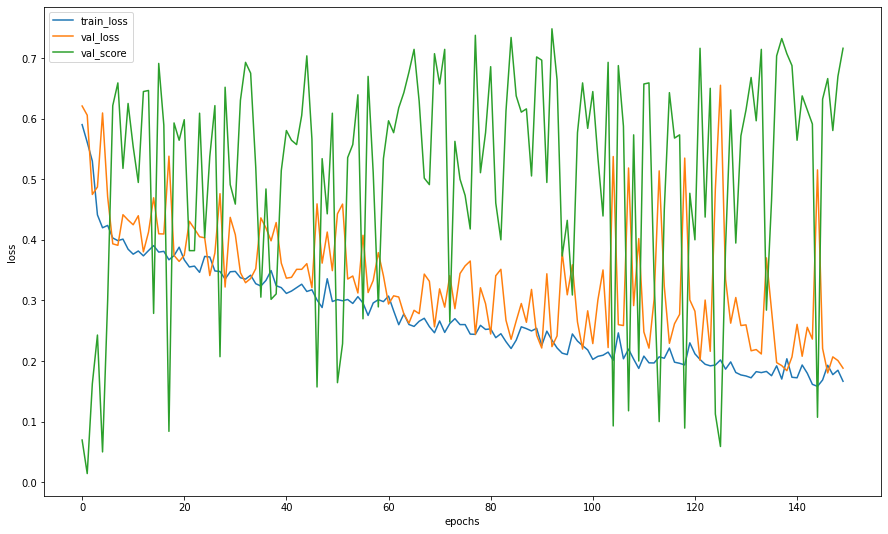

In [127]:
plt.figure(figsize=(15, 9))
plt.plot(tr_loss_dice, label="train_loss")
plt.plot(val_loss_dice, label="val_loss")
plt.plot(val_score_dice, label="val_score")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Несмотря на сильную нестабильность, на этом графике мы можем увидеть  легкое переобучение, которое начинается с ~90 эпохи, но это нормально, так как датасет небольшой

In [128]:
print(score_model(model_dice, iou_pytorch, data_val), score_model(model_dice, iou_pytorch, data_ts))

0.7107142806053162 0.6892857125827244


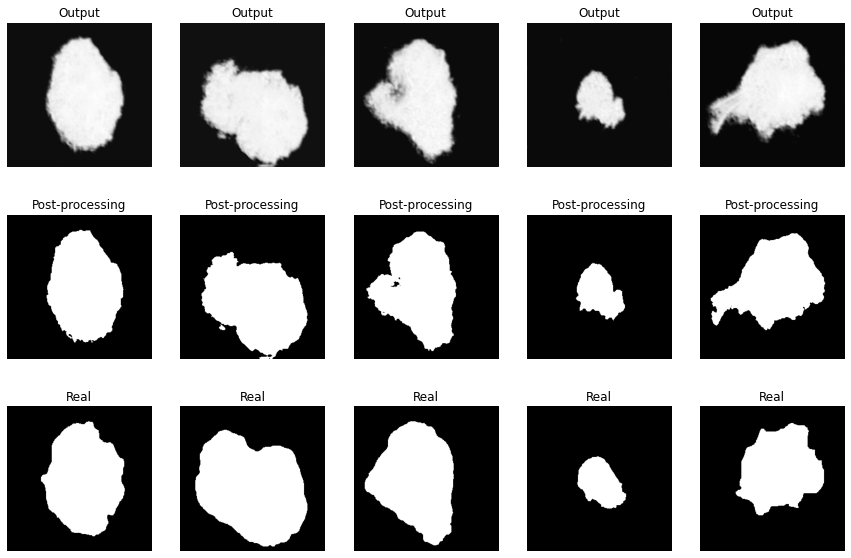

In [129]:
plot_items(model_dice, data_ts, 5)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [130]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    
    y_pred = y_pred.sigmoid()
    loss = -(((1 - y_pred) ** gamma) * y_real * (y_pred + eps).log() + (1 - y_real) * (1 - y_pred + eps).log())
    
    return loss.mean()

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 130
optim = torch.optim.AdamW(model_focal.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_loss_focal, val_loss_focal, val_score_focal = train(model_focal, optim, scheduler, focal_loss, score_model, max_epochs, data_tr, data_val)

In [132]:
torch.save(model_focal.state_dict(), 'segnet_focal.pt')

In [133]:
with open('tr_loss_focal.pickle', 'wb') as f:
    pickle.dump(tr_loss_focal, f)

with open('val_loss_focal.pickle', 'wb') as f:
    pickle.dump(val_loss_focal, f)

with open('val_score_focal.pickle', 'wb') as f:
    pickle.dump(val_score_focal, f)

In [134]:
model_focal = SegNet().to(device)

In [135]:
model_focal.load_state_dict(torch.load('segnet_focal.pt'))

<All keys matched successfully>

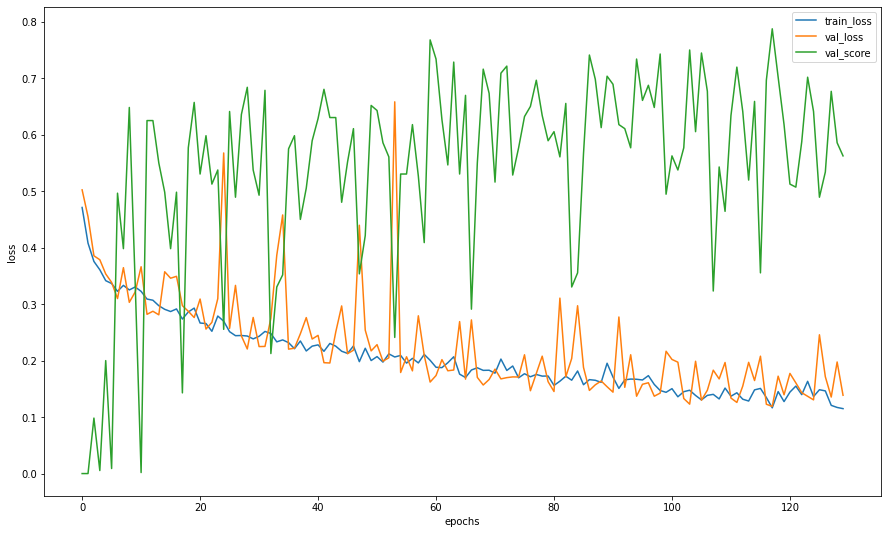

In [136]:
plt.figure(figsize=(15, 9))
plt.plot(tr_loss_focal, label="train_loss")
plt.plot(val_loss_focal, label="val_loss")
plt.plot(val_score_focal, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [137]:
print(score_model(model_focal, iou_pytorch, data_val), score_model(model_focal, iou_pytorch, data_ts))

0.5625000085149493 0.605357153075082


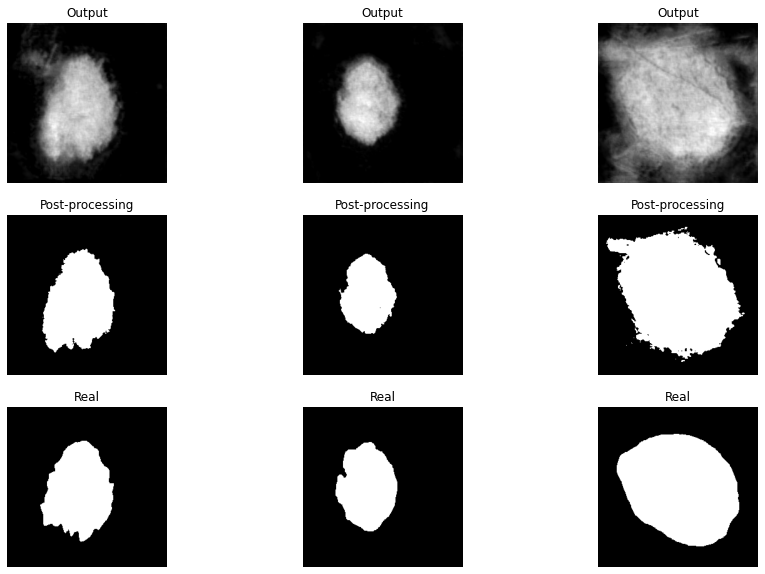

In [138]:
plot_items(model_focal, data_ts, 3)

In [142]:
def similarityloss(y_pred, y_real, eps=1e-8):
    covariance = ((y_pred - y_pred.mean()) * (y_real - y_real.mean())).sum() / (y_pred.view(-1).shape.numel() + y_real.view(-1).shape.numel())
    res = (torch.var(y_pred) + torch.var(y_real) - 2 * covariance) / (torch.var(y_pred) + torch.var(y_real) + eps)
    return res

In [143]:
model_ssim = SegNet()

In [ ]:
model_ssim = SegNet().to(device)

max_epochs = 120
optim = torch.optim.AdamW(model_ssim.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_loss_ssim, val_loss_ssim, val_score_ssim = train(model_ssim, optim, scheduler, similarityloss, score_model, max_epochs, data_tr, data_val)

In [154]:
torch.save(model_ssim.state_dict(), 'segnet_ssim.pt')

In [155]:
with open('tr_loss_ssim.pickle', 'wb') as f:
    pickle.dump(tr_loss_ssim, f)

with open('val_loss_ssim.pickle', 'wb') as f:
    pickle.dump(val_loss_ssim, f)

with open('val_score_ssim.pickle', 'wb') as f:
    pickle.dump(val_score_ssim, f)

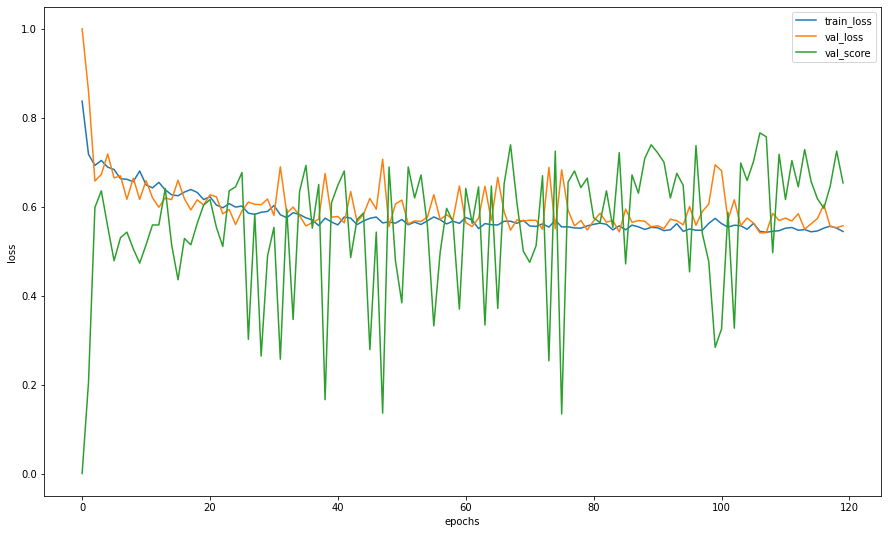

In [156]:
plt.figure(figsize=(15, 9))
plt.plot(tr_loss_ssim, label="train_loss")
plt.plot(val_loss_ssim, label="val_loss")
plt.plot(val_score_ssim, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [157]:
print(score_model(model_ssim, iou_pytorch, data_val), score_model(model_ssim, iou_pytorch, data_ts))

0.6428571513720921 0.5446428571428571


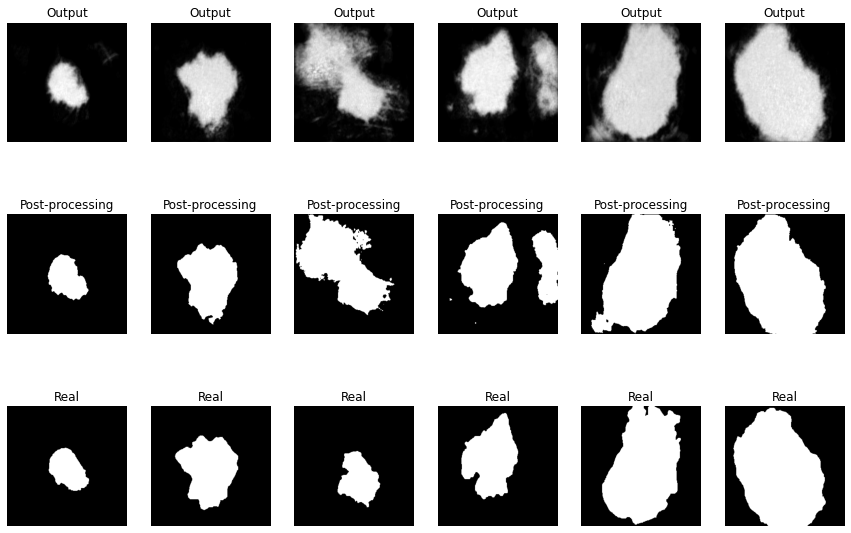

In [158]:
plot_items(model_ssim, data_ts, 6)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

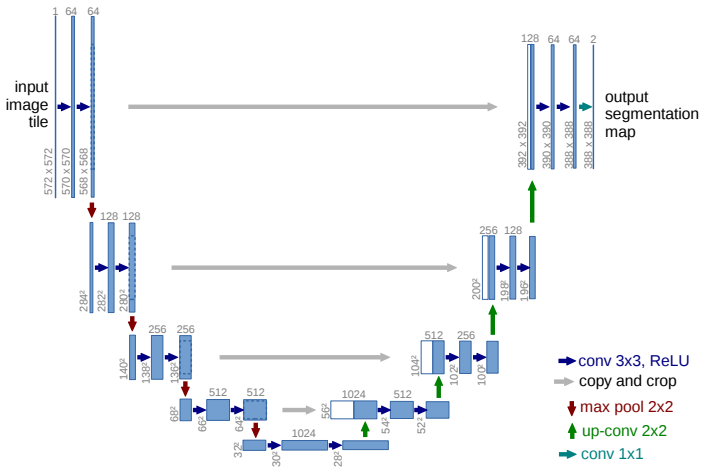

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [140]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()           
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()          
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=1,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024,
                      out_channels=512,
                      kernel_size=1,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512*2,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256*2,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128*2,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),   
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64*2,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))

        # no activation
        return d0

In [ ]:
unet_bce= UNet().to(device)

max_epochs = 100
optim = torch.optim.AdamW(unet_bce.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_unet_bce_loss, val_unet_bce_loss, val_unet_bce_score = train(unet_bce, optim, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val)

In [151]:
torch.save(unet_bce.state_dict(), 'unet_bce.pt')

In [152]:
with open('tr_unet_bce_loss.pickle', 'wb') as f:
    pickle.dump(tr_unet_bce_loss, f)

with open('val_unet_bce_loss.pickle', 'wb') as f:
    pickle.dump(val_unet_bce_loss, f)

with open('val_unet_bce_score.pickle', 'wb') as f:
    pickle.dump(val_unet_bce_score, f)

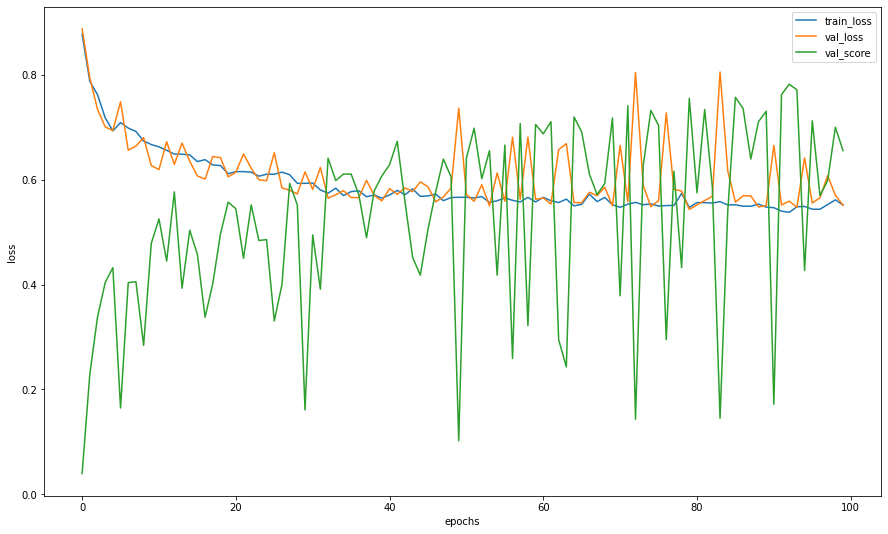

In [150]:
plt.figure(figsize=(15, 9))
plt.plot(tr_unet_bce_loss, label="train_loss")
plt.plot(val_unet_bce_loss, label="val_loss")
plt.plot(val_unet_bce_score, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

0.5839285786662783 0.5285714226109641


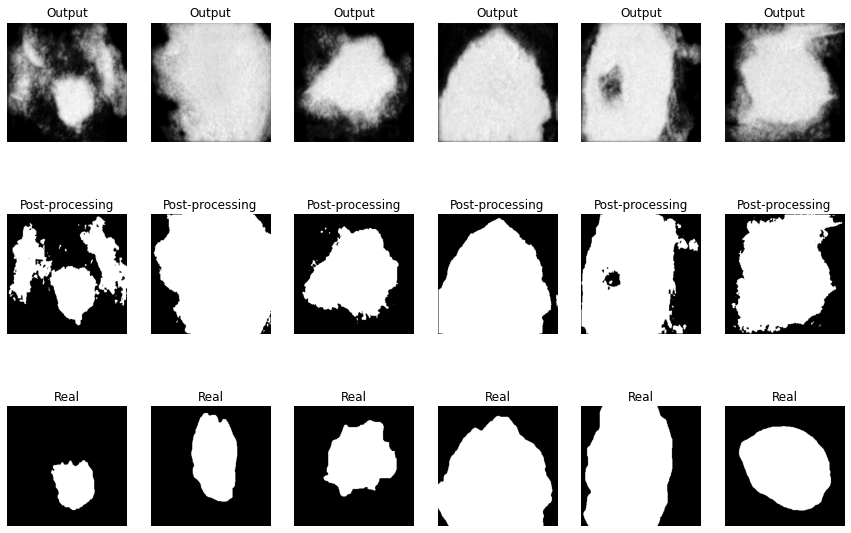

In [153]:
print(score_model(model_ssim, iou_pytorch, data_val), score_model(model_ssim, iou_pytorch, data_ts))
plot_items(model_ssim, data_ts, 6)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
unet_ssim= UNet().to(device)

max_epochs = 100
optim = torch.optim.AdamW(unet_ssi.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_unet_ssim_loss, val_unet_ssim_loss, val_unet_ssim_score = train(unet_ssim, optim, scheduler, similarityloss, score_model, max_epochs, data_tr, data_val)

In [165]:
torch.save(unet_dice.state_dict(), 'unet_dice.pt')

In [166]:
with open('tr_unet_dice_loss.pickle', 'wb') as f:
    pickle.dump(tr_unet_dice_loss, f)

with open('val_unet_dice_loss.pickle', 'wb') as f:
    pickle.dump(val_unet_dice_loss, f)

with open('val_unet_dice_score.pickle', 'wb') as f:
    pickle.dump(val_unet_dice_score, f)

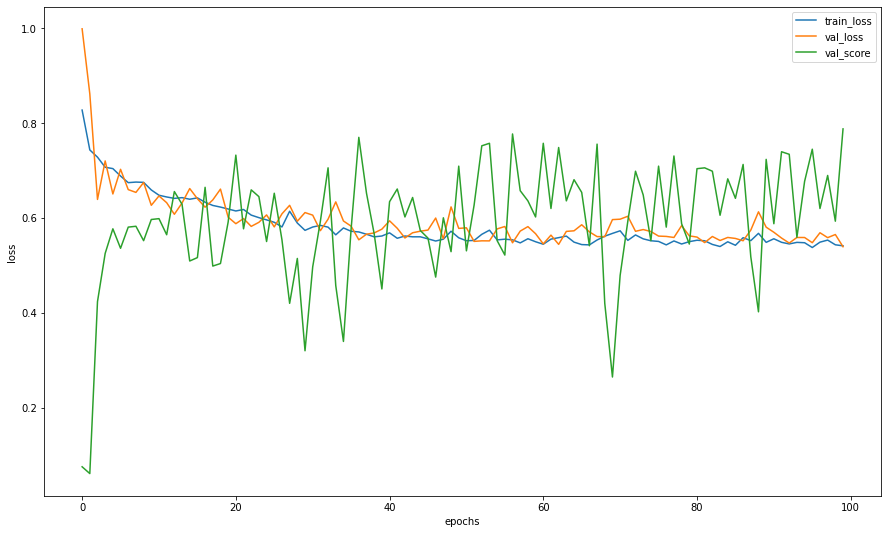

In [167]:
plt.figure(figsize=(15, 9))
plt.plot(tr_unet_dice_loss, label="train_loss")
plt.plot(val_unet_dice_loss, label="val_loss")
plt.plot(val_unet_dice_score, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

0.7660714217594692 0.7053571513720921


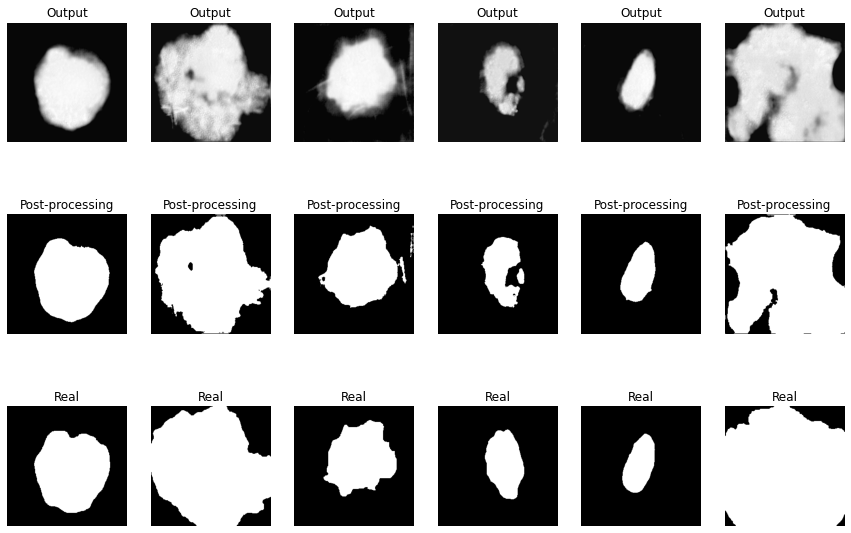

In [168]:
print(score_model(unet_dice, iou_pytorch, data_val), score_model(unet_dice, iou_pytorch, data_ts))
plot_items(unet_dice, data_ts, 6)

In [169]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()           
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()          
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=1,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024,
                      out_channels=512,
                      kernel_size=1,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512*2,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256*2,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128*2,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),   
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=64*2,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1,
                      out_channels=1,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, output_size=pre_e0.size()), pre_e0], 1))

        # no activation
        return d0

In [ ]:
unet2_bce= UNet2().to(device)

max_epochs = 100
optim = torch.optim.AdamW(unet2_bce.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_unet2_bce_loss, val_unet2_bce_loss, val_unet2_bce_score = train(unet2_bce, optim, scheduler, bce_loss, score_model, max_epochs, data_tr, data_val)

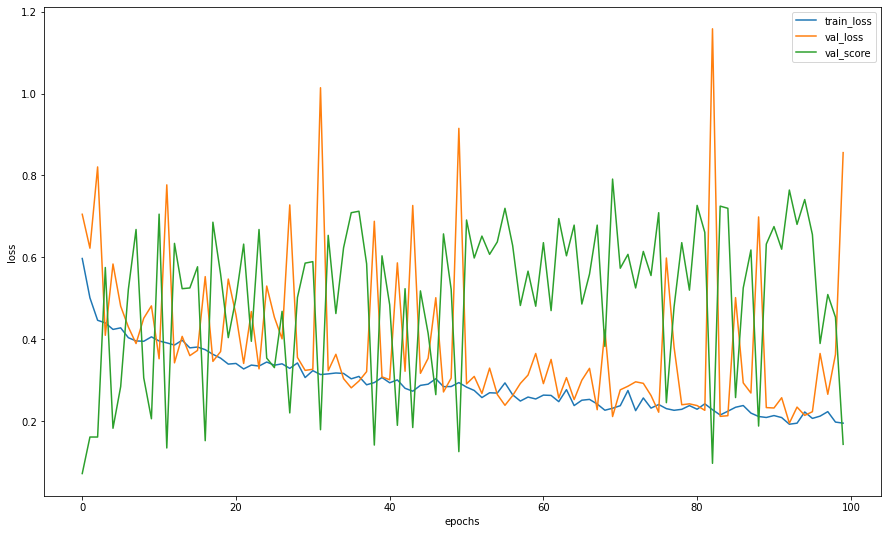

In [171]:
plt.figure(figsize=(15, 9))
plt.plot(tr_unet2_bce_loss, label="train_loss")
plt.plot(val_unet2_bce_loss, label="val_loss")
plt.plot(val_unet2_bce_score, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
unet2_dice= UNet2().to(device)

max_epochs = 100
optim = torch.optim.AdamW(unet2_dice.parameters(), lr=0.00100, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[30,60], gamma=0.8)
tr_unet2_dice_loss, val_unet2_dice_loss, val_unet2_dice_score = train(unet2_dice, optim, scheduler, dice_loss, score_model, max_epochs, data_tr, data_val)

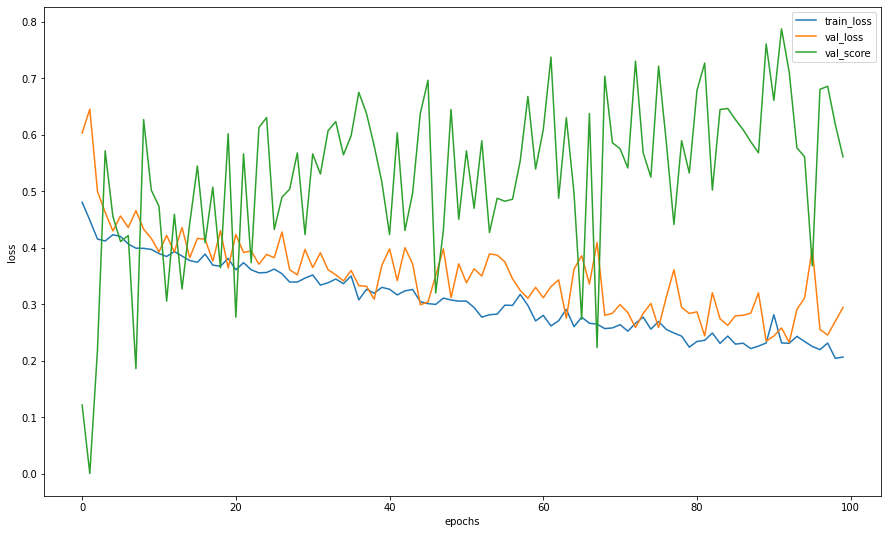

In [173]:
plt.figure(figsize=(15, 9))
plt.plot(tr_unet2_dice_loss, label="train_loss")
plt.plot(val_unet2_dice_loss, label="val_loss")
plt.plot(val_unet2_dice_score, label="val_score")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Моя гипотеза заключается в том, что модель, использующая скип-коннекшены будет давать более высокий скор. Давайте посмотрим на сглаженные графики скора трех моделей

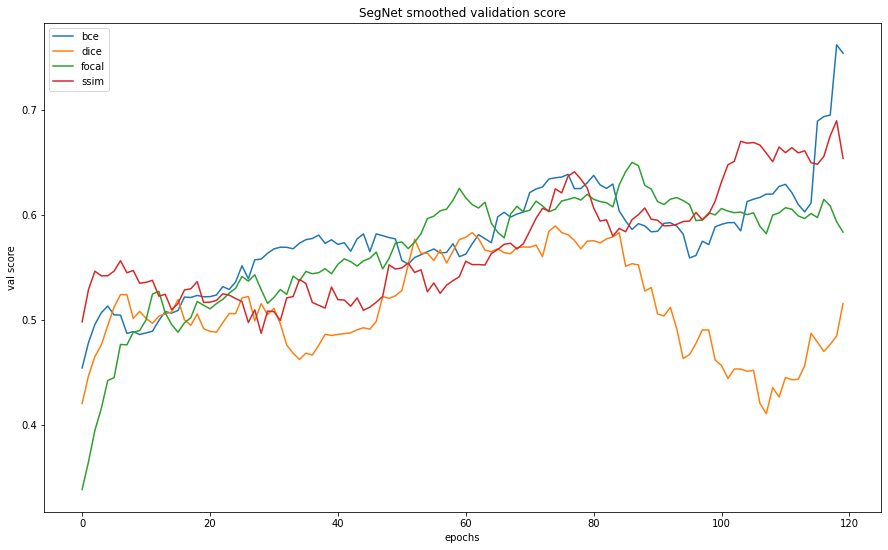

In [186]:
from statistics import mean 

ind=3
results = [
    [val_score_bce, 'bce'],
    [val_score_dice, 'dice'],
    [val_score_focal, 'focal'],
    [val_score_ssim, 'ssim']
]

plt.figure(figsize=(15, 9))
window=20
for r in results:
    v = [mean(r[0][x:x+window]) for x in range(120)]
    plt.plot(v, label=r[1])

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val score")
plt.title("SegNet smoothed validation score")
plt.show()

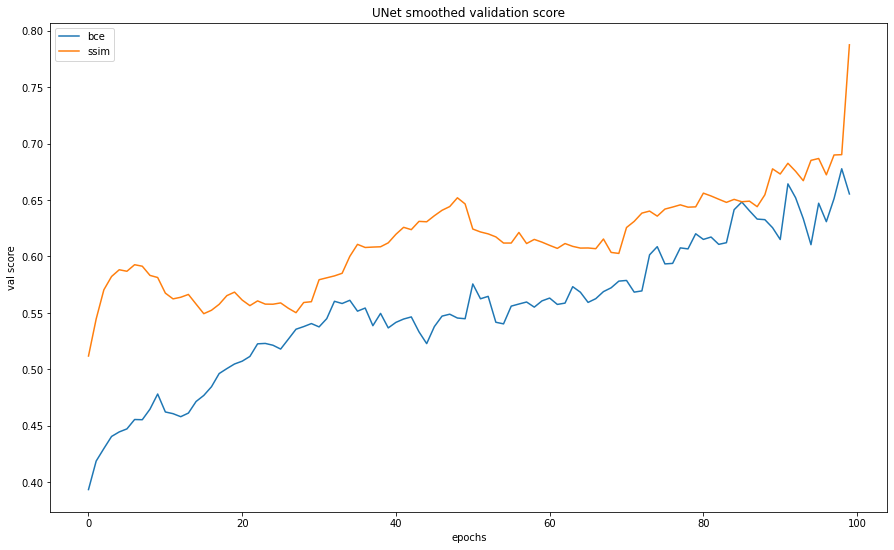

In [193]:
from statistics import mean 

ind=3
results = [
    [val_unet_bce_score, 'bce'],
    [val_unet_dice_score, 'ssim']
]

plt.figure(figsize=(15, 9))
window=20
for r in results:
    v = [mean(r[0][x:x+window]) for x in range(100)]
    plt.plot(v, label=r[1])

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val score")
plt.title("UNet smoothed validation score")
plt.show()

В целом по результатам обучения трёх разных моделей можно сделать вывод, что составленны они корректно (это была самая сложная часть работы), поскольку обучение происходит (с выходом на плато), скор растёт, лосс падает. Целью работы было найти наилучшую модель в смысле предсказания маски (на поиск ещё и по другим критериям, например по времени обучения, сил не осталось).¶



Из диаграмм видно, что UNet c MaxPool2d/MaxUnpool2d является лучшей моделью. Это подтверждает основную гипотезу.